# Download dataset

1. Go to your kaggle account, scroll to API section and click on Create New API Token - It will download kaggle.json file on your machine.

2. Save that file into google drive and give the path to the folder, where you have saved the kaggle.json file in below command.


```
import os
os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/workspace/kaggle'
```

3. That's it. Now you can access your kaggle account from colab. Now to download the dataset from the kaggle run this command.


```
!pip install kaggle
!kaggle datasets download -d crowww/a-large-scale-fish-dataset
```



In [ ]:
import os
os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/workspace/kaggle'

In [ ]:
!pip install kaggle
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:55<00:00, 18.7MB/s]
100% 3.24G/3.24G [00:55<00:00, 62.7MB/s]


In [ ]:
# Create another folder to save the data and unzip the downloaded data into that folder.
!mkdir "/content/large-scale-fish-dataset"
!!unzip -qq "/content/a-large-scale-fish-dataset.zip" -d "/content/large-scale-fish-dataset"

[]

# Use this to run .py file
Run with .py file here for run in colab below it.

In [1]:
%cd "/content/drive/MyDrive/workspace/fish-cls/model-1/src"
!python main.py --data_path="/content/large-scale-fish-dataset/Fish_Dataset/Fish_Dataset" \
                --weigths_path="/content/drive/MyDrive/workspace/fish-cls/model-1/outputs/trained_weights" \
                --test_img="/content/drive/MyDrive/workspace/fish-cls/model-1/test_images" \
                --test

/content/drive/MyDrive/workspace/fish-cls/model-1/src
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00113.png -> pred: Red Mullet
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00136.png -> pred: Shrimp
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00350.png -> pred: Black Sea Sprat
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00439.png -> pred: Sea Bass
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00545.png -> pred: Shrimp
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00649.png -> pred: Shrimp
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00702.png -> pred: Trout
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00791.png -> pred: Red Mullet
image path: /content/drive/MyDrive/workspace/fish-cls/model-1/test_images/00808.png -> pred: Striped Red Mullet


# Classification model 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import random
from pathlib import Path
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

In [ ]:
folder_path = Path("/content/large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")
file_path = list(folder_path.glob(r"**/*.png"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

# Convert to series then contact them as a data frame, rename the columns
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path,labels], axis=1)
df.columns = ['image', 'label']
# Drop all the images that ends with (GT)
df = df[df["image"].apply(lambda x: x[-2:] != "GT")]
df = df.reset_index(drop=True)
# Show the last 5 rows
df.tail()

,image,label
17995,/content/large-scale-fish-dataset/Fish_Dataset...,Sea Bass
17996,/content/large-scale-fish-dataset/Fish_Dataset...,Sea Bass
17997,/content/large-scale-fish-dataset/Fish_Dataset...,Sea Bass
17998,/content/large-scale-fish-dataset/Fish_Dataset...,Sea Bass
17999,/content/large-scale-fish-dataset/Fish_Dataset...,Sea Bass


In [ ]:
classes = df['label'].unique()
print(f'\nThe Classes:\n {classes} ')


The Classes:
 ['Shrimp' 'Shrimp GT' 'Gilt-Head Bream GT' 'Gilt-Head Bream'
 'Black Sea Sprat' 'Black Sea Sprat GT' 'Trout GT' 'Trout'
 'Striped Red Mullet' 'Striped Red Mullet GT' 'Hourse Mackerel GT'
 'Hourse Mackerel' 'Red Mullet GT' 'Red Mullet' 'Red Sea Bream GT'
 'Red Sea Bream' 'Sea Bass GT' 'Sea Bass'] 


In [ ]:
# Make a list that contains all the file paths for images and it's label
folder_path = Path("/content/large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")
file_Path = list(folder_path.glob(r"**/*.png"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_Path))

# Convert to series then contact them as a data frame, rename the columns
file_Path = pd.Series(file_Path).astype(str)
labels = pd.Series(labels)
df = Main_Data = pd.concat([file_Path, labels],axis=1)
df.columns = ['image', 'label']
# Drop all the images that ends with (GT)
df = df[df["label"].apply(lambda x: x[-2:] != "GT")]
df = df.reset_index(drop=True)
# Get a 500 random values/rows
rand = random.sample(range(len(df)), 500)
# Make the random 500 as a validation data
validation_set = pd.DataFrame(df.iloc[rand, :].values, columns=['image', 'label'])
# Drop the 500 from the orignal data set
df.drop(rand, inplace=True)
# Get a 9 random rows/values from the validation set
rand = random.sample(range(len(validation_set)), 9)
# from the 9 random Create the test set 
test_set = pd.DataFrame(validation_set.iloc[rand, :].values, columns=['image', 'label'])
# Drop the 9 from the validation set
validation_set.drop(rand, inplace=True)
print('The number of unique values in the label column: ',len(df['label'].unique()))


The number of unique values in the label column:  9


In [ ]:
num_epochs = 50
n_classes = 9
batch_size = 32
width = 64
height = 64
n_channels = 3
input_shape = (width, height, n_channels)
out_path = "/content/drive/MyDrive/workspace/fish-cls/outputs"

In [ ]:
DATADIR = ''
train_data_generator = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.2
)
data_generator = ImageDataGenerator(
    rescale=1./255
)
training_data_frame = train_data_generator.flow_from_dataframe(
    dataframe=df, 
    directory=DATADIR, 
    x_col='image', 
    y_col='label', 
    target_size=(width, height), 
    class_mode='categorical',
    batch_size=batch_size
)
validation_data_frame = data_generator.flow_from_dataframe(
    dataframe=validation_set, 
    directory=DATADIR, 
    x_col='image', 
    y_col='label', 
    target_size=(width, height), 
    class_mode='categorical',
    batch_size=batch_size
)
test_data_frame = data_generator.flow_from_dataframe(
    dataframe=test_set, 
    directory=DATADIR, 
    x_col='image', 
    y_col='label', 
    target_size=(width, height), 
    class_mode='categorical', 
    shuffle=False,
    batch_size=batch_size
)

Found 8500 validated image filenames belonging to 9 classes.
Found 491 validated image filenames belonging to 9 classes.
Found 9 validated image filenames belonging to 7 classes.


In [ ]:
def get_model(input_shape, n_classes):
    # Define the model
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    return model

In [ ]:
model = get_model(input_shape, n_classes)
model.compile(
    RMSprop(lr=0.0001), 
    loss="categorical_crossentropy", 
    metrics=[metrics.AUC(name='auc'), 'accuracy']
)

In [ ]:
es_callback = EarlyStopping(monitor='val_auc', mode='max', patience=5,
                    verbose=1, min_delta=0.005, restore_best_weights=True)

history = model.fit(training_data_frame,
                    steps_per_epoch=training_data_frame.samples//batch_size,
                    epochs = num_epochs,
                    validation_data=validation_data_frame,
                    validation_steps=validation_data_frame.samples//batch_size,
                    callbacks= [es_callback],
                    verbose=1)

Epoch 1/50
265/265 [==============================] - 90s 340ms/step - loss: 1.7542 - auc: 0.7827 - accuracy: 0.3348 - val_loss: 1.2031 - val_auc: 0.9134 - val_accuracy: 0.5625
Epoch 2/50
265/265 [==============================] - 86s 324ms/step - loss: 1.1812 - auc: 0.9118 - accuracy: 0.5724 - val_loss: 0.7865 - val_auc: 0.9633 - val_accuracy: 0.7208
Epoch 3/50
265/265 [==============================] - 84s 316ms/step - loss: 0.9155 - auc: 0.9471 - accuracy: 0.6671 - val_loss: 0.6175 - val_auc: 0.9771 - val_accuracy: 0.7667
Epoch 4/50
265/265 [==============================] - 84s 317ms/step - loss: 0.7180 - auc: 0.9667 - accuracy: 0.7461 - val_loss: 0.4726 - val_auc: 0.9863 - val_accuracy: 0.8438
Epoch 5/50
265/265 [==============================] - 84s 316ms/step - loss: 0.5672 - auc: 0.9784 - accuracy: 0.7974 - val_loss: 0.4417 - val_auc: 0.9870 - val_accuracy: 0.8438
Epoch 6/50
265/265 [==============================] - 84s 317ms/step - loss: 0.4784 - auc: 0.9841 - accuracy: 0.830

In [ ]:
model.save_weights(f"{out_path}/trained_weights/fish_classification")

# Test the model



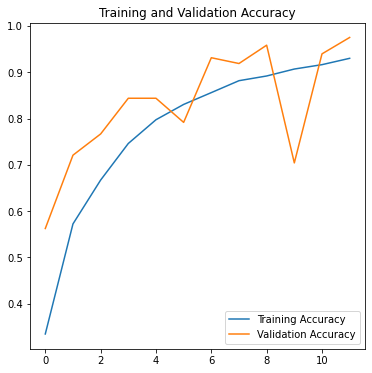

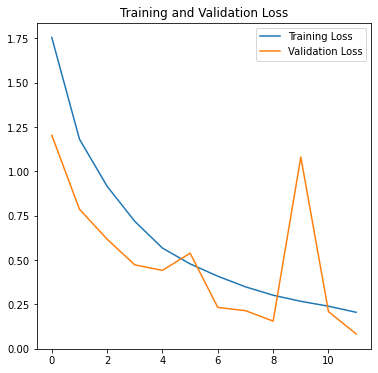

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(20)

plt.figure(figsize=(6, 6))
# plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig(f"{out_path}/images/acc.png")

# plt.subplot(2, 2, 2)
plt.figure(figsize=(6, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(f"{out_path}/images/loss.png")
# plt.show()

In [ ]:
model = get_model(input_shape, n_classes)
model.load_weights(f"{out_path}/trained_weights/fish_classification")

Prediction Dict:  {'Black Sea Sprat': 0, 'Gilt-Head Bream': 1, 'Hourse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}
Max index:  [7, 7, 1, 2, 5, 3, 3, 0, 3]
Predicted:  Striped Red Mullet /Real:  Striped Red Mullet
Predicted:  Striped Red Mullet /Real:  Striped Red Mullet
Predicted:  Gilt-Head Bream /Real:  Gilt-Head Bream
Predicted:  Hourse Mackerel /Real:  Hourse Mackerel
Predicted:  Sea Bass /Real:  Sea Bass
Predicted:  Red Mullet /Real:  Red Mullet
Predicted:  Red Mullet /Real:  Red Mullet
Predicted:  Black Sea Sprat /Real:  Black Sea Sprat
Predicted:  Red Mullet /Real:  Shrimp


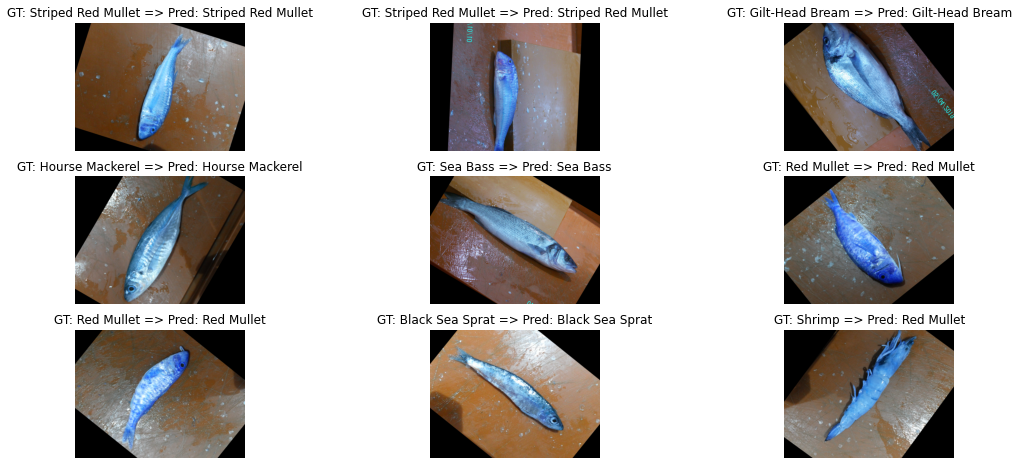

In [ ]:
# Print the class indices 
print("Prediction Dict: ", training_data_frame.class_indices)
# Predict on the test data 
pred = model.predict(test_data_frame)
# Create a class/labels dictionary
classDict = { 
                 0:'Black Sea Sprat',
                 1:'Gilt-Head Bream',
                 2:'Hourse Mackerel',
                 3:'Red Mullet',
                 4:'Red Sea Bream',
                 5:'Sea Bass',
                 6:'Shrimp',
                 7:'Striped Red Mullet',
                 8:'Trout'}

# Make a data frame that contains the probability for each class
outputDf = pd.DataFrame(pred)
# Get the index of the max probability from the output Data frame
maxIndex = list(outputDf.idxmax(axis=1))
# Print the max index
print("Max index: ", maxIndex)
# Make a loop in range the length of the test data (5)
fig, axes = plt.subplots(3, 3, figsize =(18, 8))
i = 0
j = 0
for p in range(len(test_set)):
    # Read the image 
    image = cv.imread(test_set['image'][p])
    # The title of the plot which is the predicted label
    print('Predicted: ',classDict.get(maxIndex[p], "error"),'/Real: ',test_set['label'][p])
    # axes[i].title(classDict.get(maxIndex[i], "error"))
    # Show the actual image
    axes[j, i].imshow(image)
    axes[j, i].axis("off")
    axes[j, i].set_title(f"GT: {test_set['label'][p]} => Pred: {classDict.get(maxIndex[p], 'error')}")

    i += 1
    if i == 3:
        j += 1
        i = 0
fig.savefig(f"{out_path}/images/results.png")